In [1]:
from matplotlib import pyplot
from functools import partial
import numpy
import pandas
import ROOT

Welcome to JupyROOT 6.27/01


In [2]:
### UTILS
def round_to_nearest_5(n) -> int:
    r = round(n, -1)
    return r if r > n  else r + 5

def get_y_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    y_1 = graph1.GetY()
    n_2 = graph2.GetN()
    y_2 = graph2.GetY()

    ymin_1 = ROOT.TMath.MinElement(n_1, y_1)
    ymax_1 = ROOT.TMath.MaxElement(n_1, y_1)

    ymin_2 = ROOT.TMath.MinElement(n_2, y_2)
    ymax_2 = ROOT.TMath.MaxElement(n_2, y_2)
    
    return min(ymin_1, ymin_2), max(ymax_1, ymax_2)

def get_x_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    x_1 = graph1.GetX()
    n_2 = graph2.GetN()
    x_2 = graph2.GetX()

    xmin_1 = ROOT.TMath.MinElement(n_1, x_1)
    xmax_1 = ROOT.TMath.MaxElement(n_1, x_1)

    xmin_2 = ROOT.TMath.MinElement(n_2, x_2)
    xmax_2 = ROOT.TMath.MaxElement(n_2, x_2)
    
    return min(xmin_1, xmin_2), max(xmax_1, xmax_2)

def create_mpl_tcolors() -> dict[str, ROOT.TColor]:
    import matplotlib.colors as mcolors
    return {
        name: ROOT.TColor.GetColor(color)
        for name, color in mcolors.TABLEAU_COLORS.items()
        
    }

PYPLOT_TCOLORS = create_mpl_tcolors()

In [3]:
df = pandas.read_csv("data_remote.csv")
df

,scheduler,ncores,npartitions,nrun,time
0,dask,128,128,1,6844
1,dask,128,128,2,5770
2,dask,128,128,3,7300
3,dask,128,128,4,6829
4,dask,128,128,5,6359
...,...,...,...,...,...
145,dask,2048,4096,6,185
146,dask,2048,4096,7,194
147,dask,2048,4096,8,205
148,dask,2048,4096,9,188


In [4]:
df.groupby(["scheduler","ncores","npartitions"])["time"].mean()

scheduler  ncores  npartitions
dask       32      32             12727.0
                   64              8755.6
                   128             8972.0
           64      64              7244.3
                   128             5899.7
           128     128             5098.6
                   256             2660.6
           256     256             3761.9
                   512             1918.5
           512     1024            1044.0
           1024    2048             601.4
           2048    4096             215.4
spark      32      64             10075.1
           64      128             5867.3
           128     256             3787.0
Name: time, dtype: float64

In [5]:
df1 = df[(df["npartitions"] == df["ncores"] * 2) & (df["scheduler"] == "dask")].copy()
df1 = df1.sort_values(["ncores", "nrun"])
df1["nodes"] = df1["ncores"].apply(lambda x: int(x/32))
df1["time_m"] = df1["time"] / 60
df1

,scheduler,ncores,npartitions,nrun,time,nodes,time_m
70,dask,32,64,1,8694,1,144.900000
71,dask,32,64,2,8758,1,145.966667
72,dask,32,64,3,9455,1,157.583333
73,dask,32,64,4,8968,1,149.466667
74,dask,32,64,5,8565,1,142.750000
...,...,...,...,...,...,...,...
145,dask,2048,4096,6,185,64,3.083333
146,dask,2048,4096,7,194,64,3.233333
147,dask,2048,4096,8,205,64,3.416667
148,dask,2048,4096,9,188,64,3.133333


Info in <TCanvas::Print>: png file runtime_dask_remote.png has been created


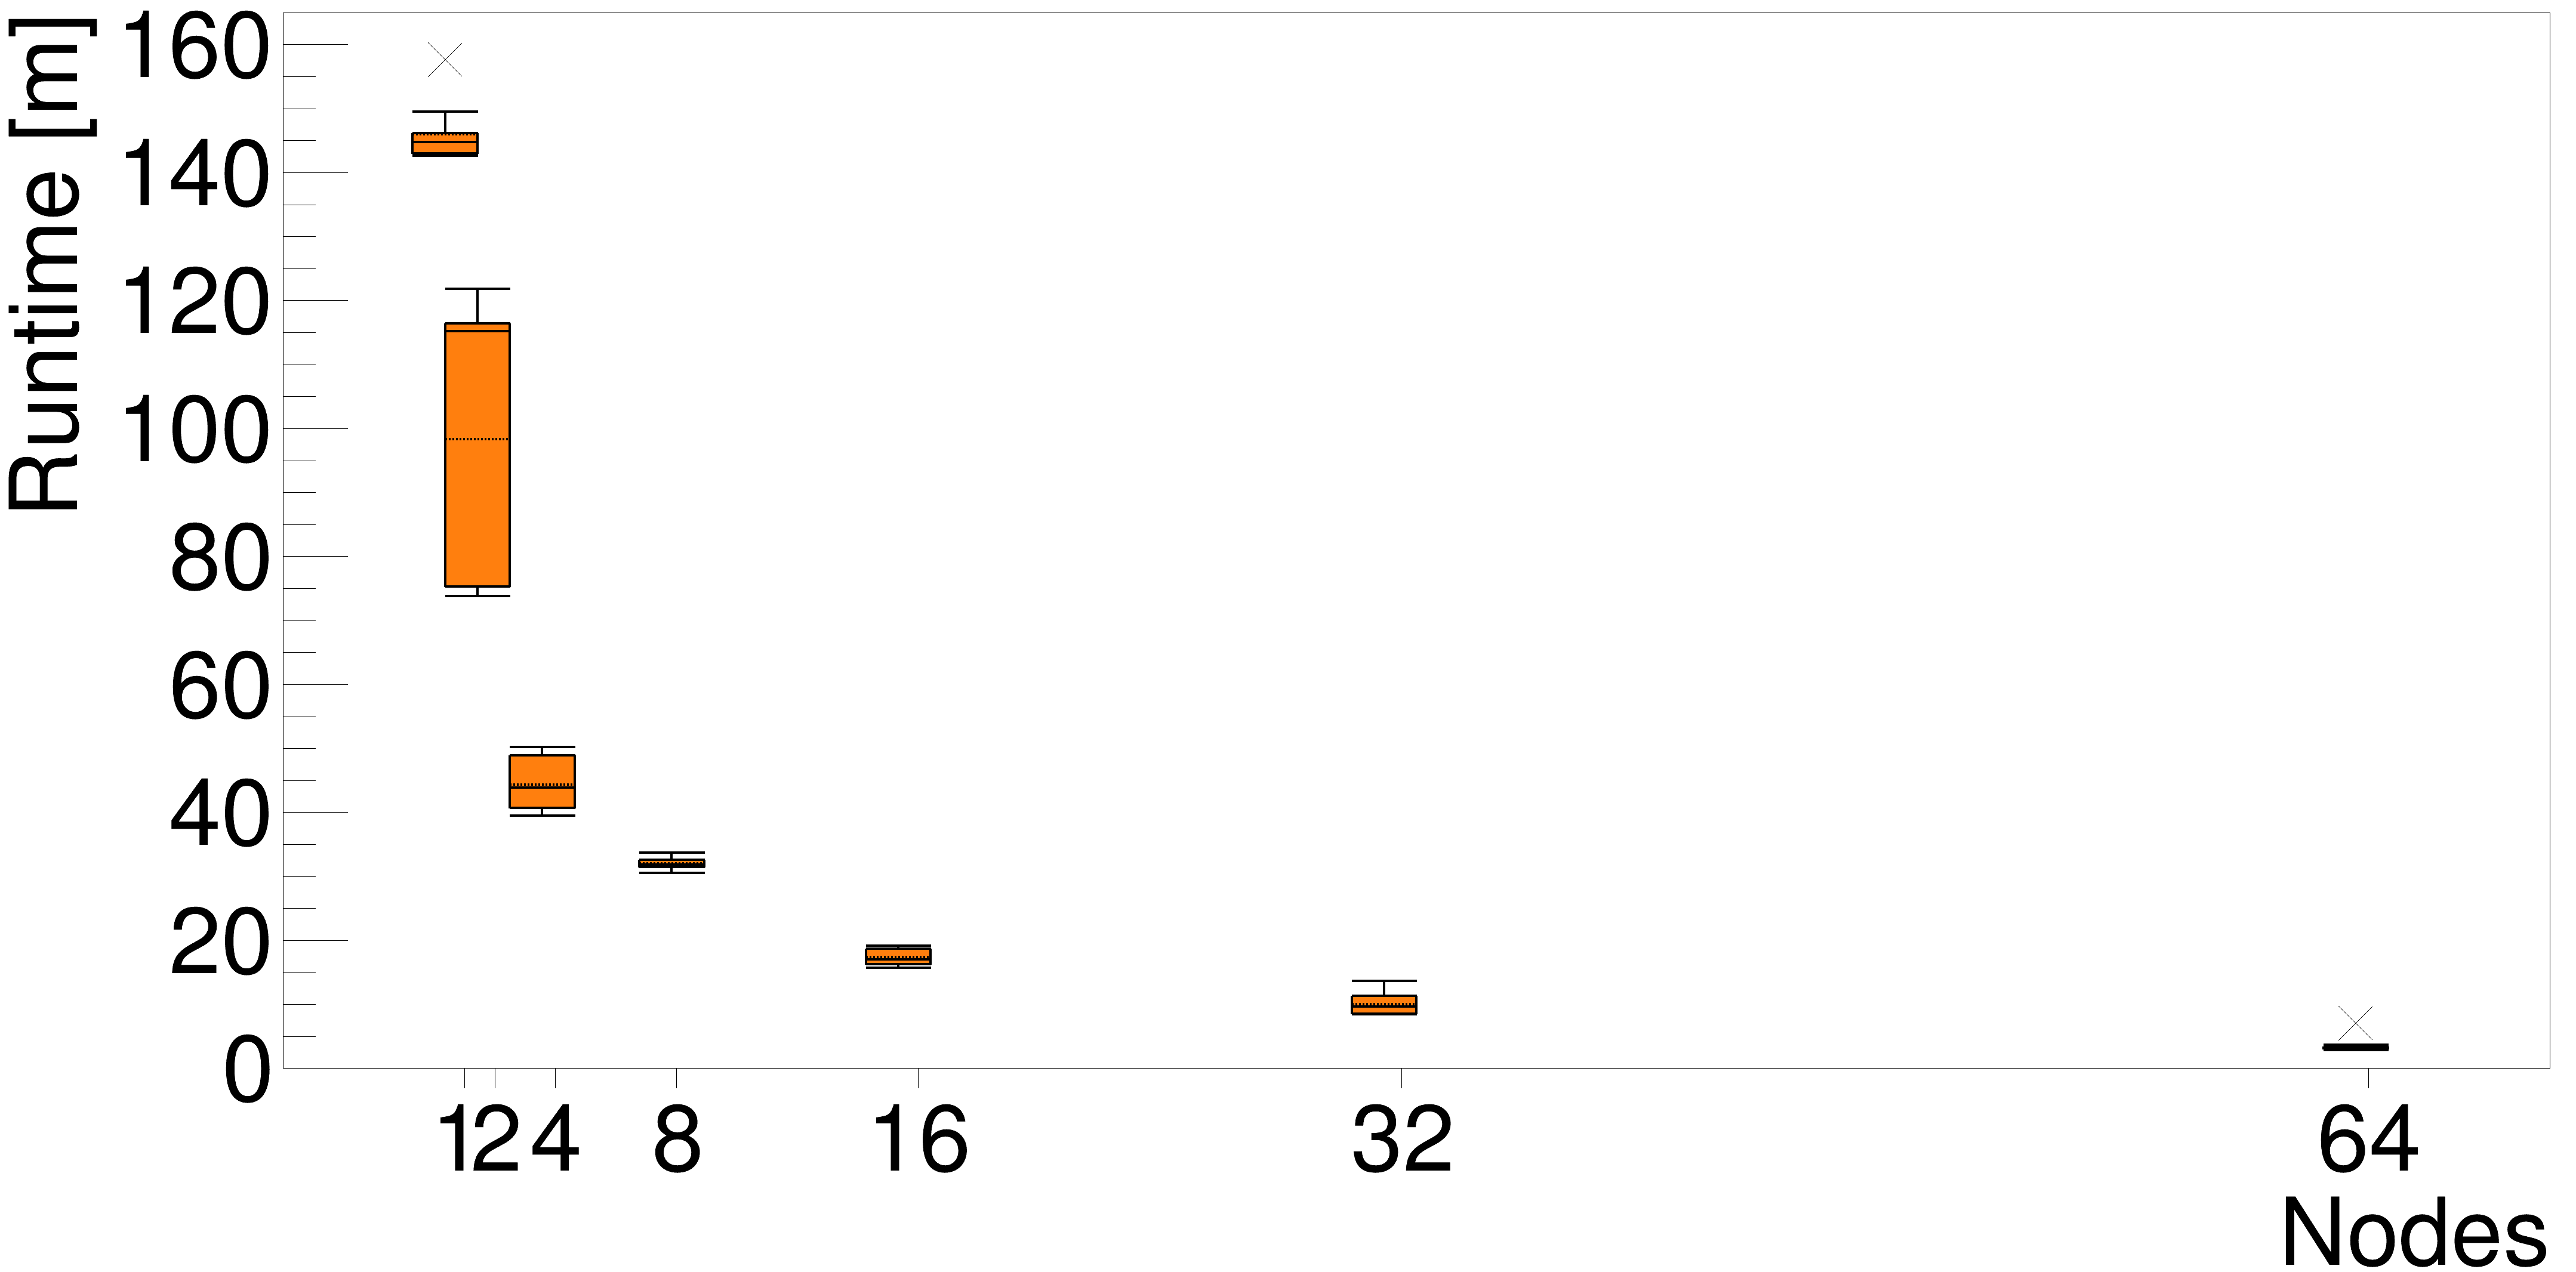

In [6]:
# Data
xcol = df1["nodes"]
ycol = df1["time_m"]
nbinsx = int(xcol.max() + 1) + 5
nbinsy = 1000
xmax = nbinsx
ymax = round_to_nearest_5(ycol.max()) + 5

# Canvas creation
width = 4320
height = 2160
c = ROOT.TCanvas("c", "", width, height)
c.SetRightMargin(0.01)
c.SetLeftMargin(0.11)
c.SetTopMargin(0.01)
c.SetBottomMargin(0.16)


# Histogram filling
hbox = ROOT.TH2F("hbox", "", nbinsx, -5, xmax, nbinsy, 0, ymax)
for x, y in zip(xcol, ycol):
    hbox.Fill(x, y)

# Histogram options
hbox.SetBarWidth(2)
hbox.SetBarOffset(-0.5)
hbox.SetLineColor(ROOT.kBlack)
hbox.SetFillColor(PYPLOT_TCOLORS["tab:orange"])
hbox.SetLineWidth(4)
hbox.SetMarkerSize(10)

# X Axis options
xaxis = hbox.GetXaxis()
xaxis.SetNdivisions(nbinsx, 1, 0)
xaxis.SetTitle("Nodes")
xaxis.SetTitleSize(0.08)
xaxis.SetLabelSize(0)
xaxis.SetTickLength(0)


# Y Axis options
yaxis = hbox.GetYaxis()
yaxis.SetTitle("Runtime [m]")
yaxis.SetTitleOffset(0.7)
yaxis.SetTitleSize(0.08)
yaxis.SetLabelSize(0.08)
yaxis.SetNdivisions(10, 5, 0)

# Legend
hbox.SetStats(0)

# Draw and save
# String option for drawing: "CANDLE(zhpawMmb)"
# a = 1 anchors
# w = 2 whiskers 1.5*iqr
# M = 1 median drawn as dashed line
# m = 1 median as solid line
# b = 1 draw box
hbox.Draw("CANDLEX2")


# Custom labels on x axis
xlabels = []
xticks = []
for x in xcol.unique():
    x = int(x)
    xt = ROOT.TLatex(x, -16, str(x))
    xt.SetTextSize(0.08)
    xt.SetTextFont(42)
    if x == 1: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,-3)
    xl.Draw()
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_dask_remote.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hbox (Potential memory leak).
Info in <TCanvas::Print>: png file runtime_dask_remote.png has been created


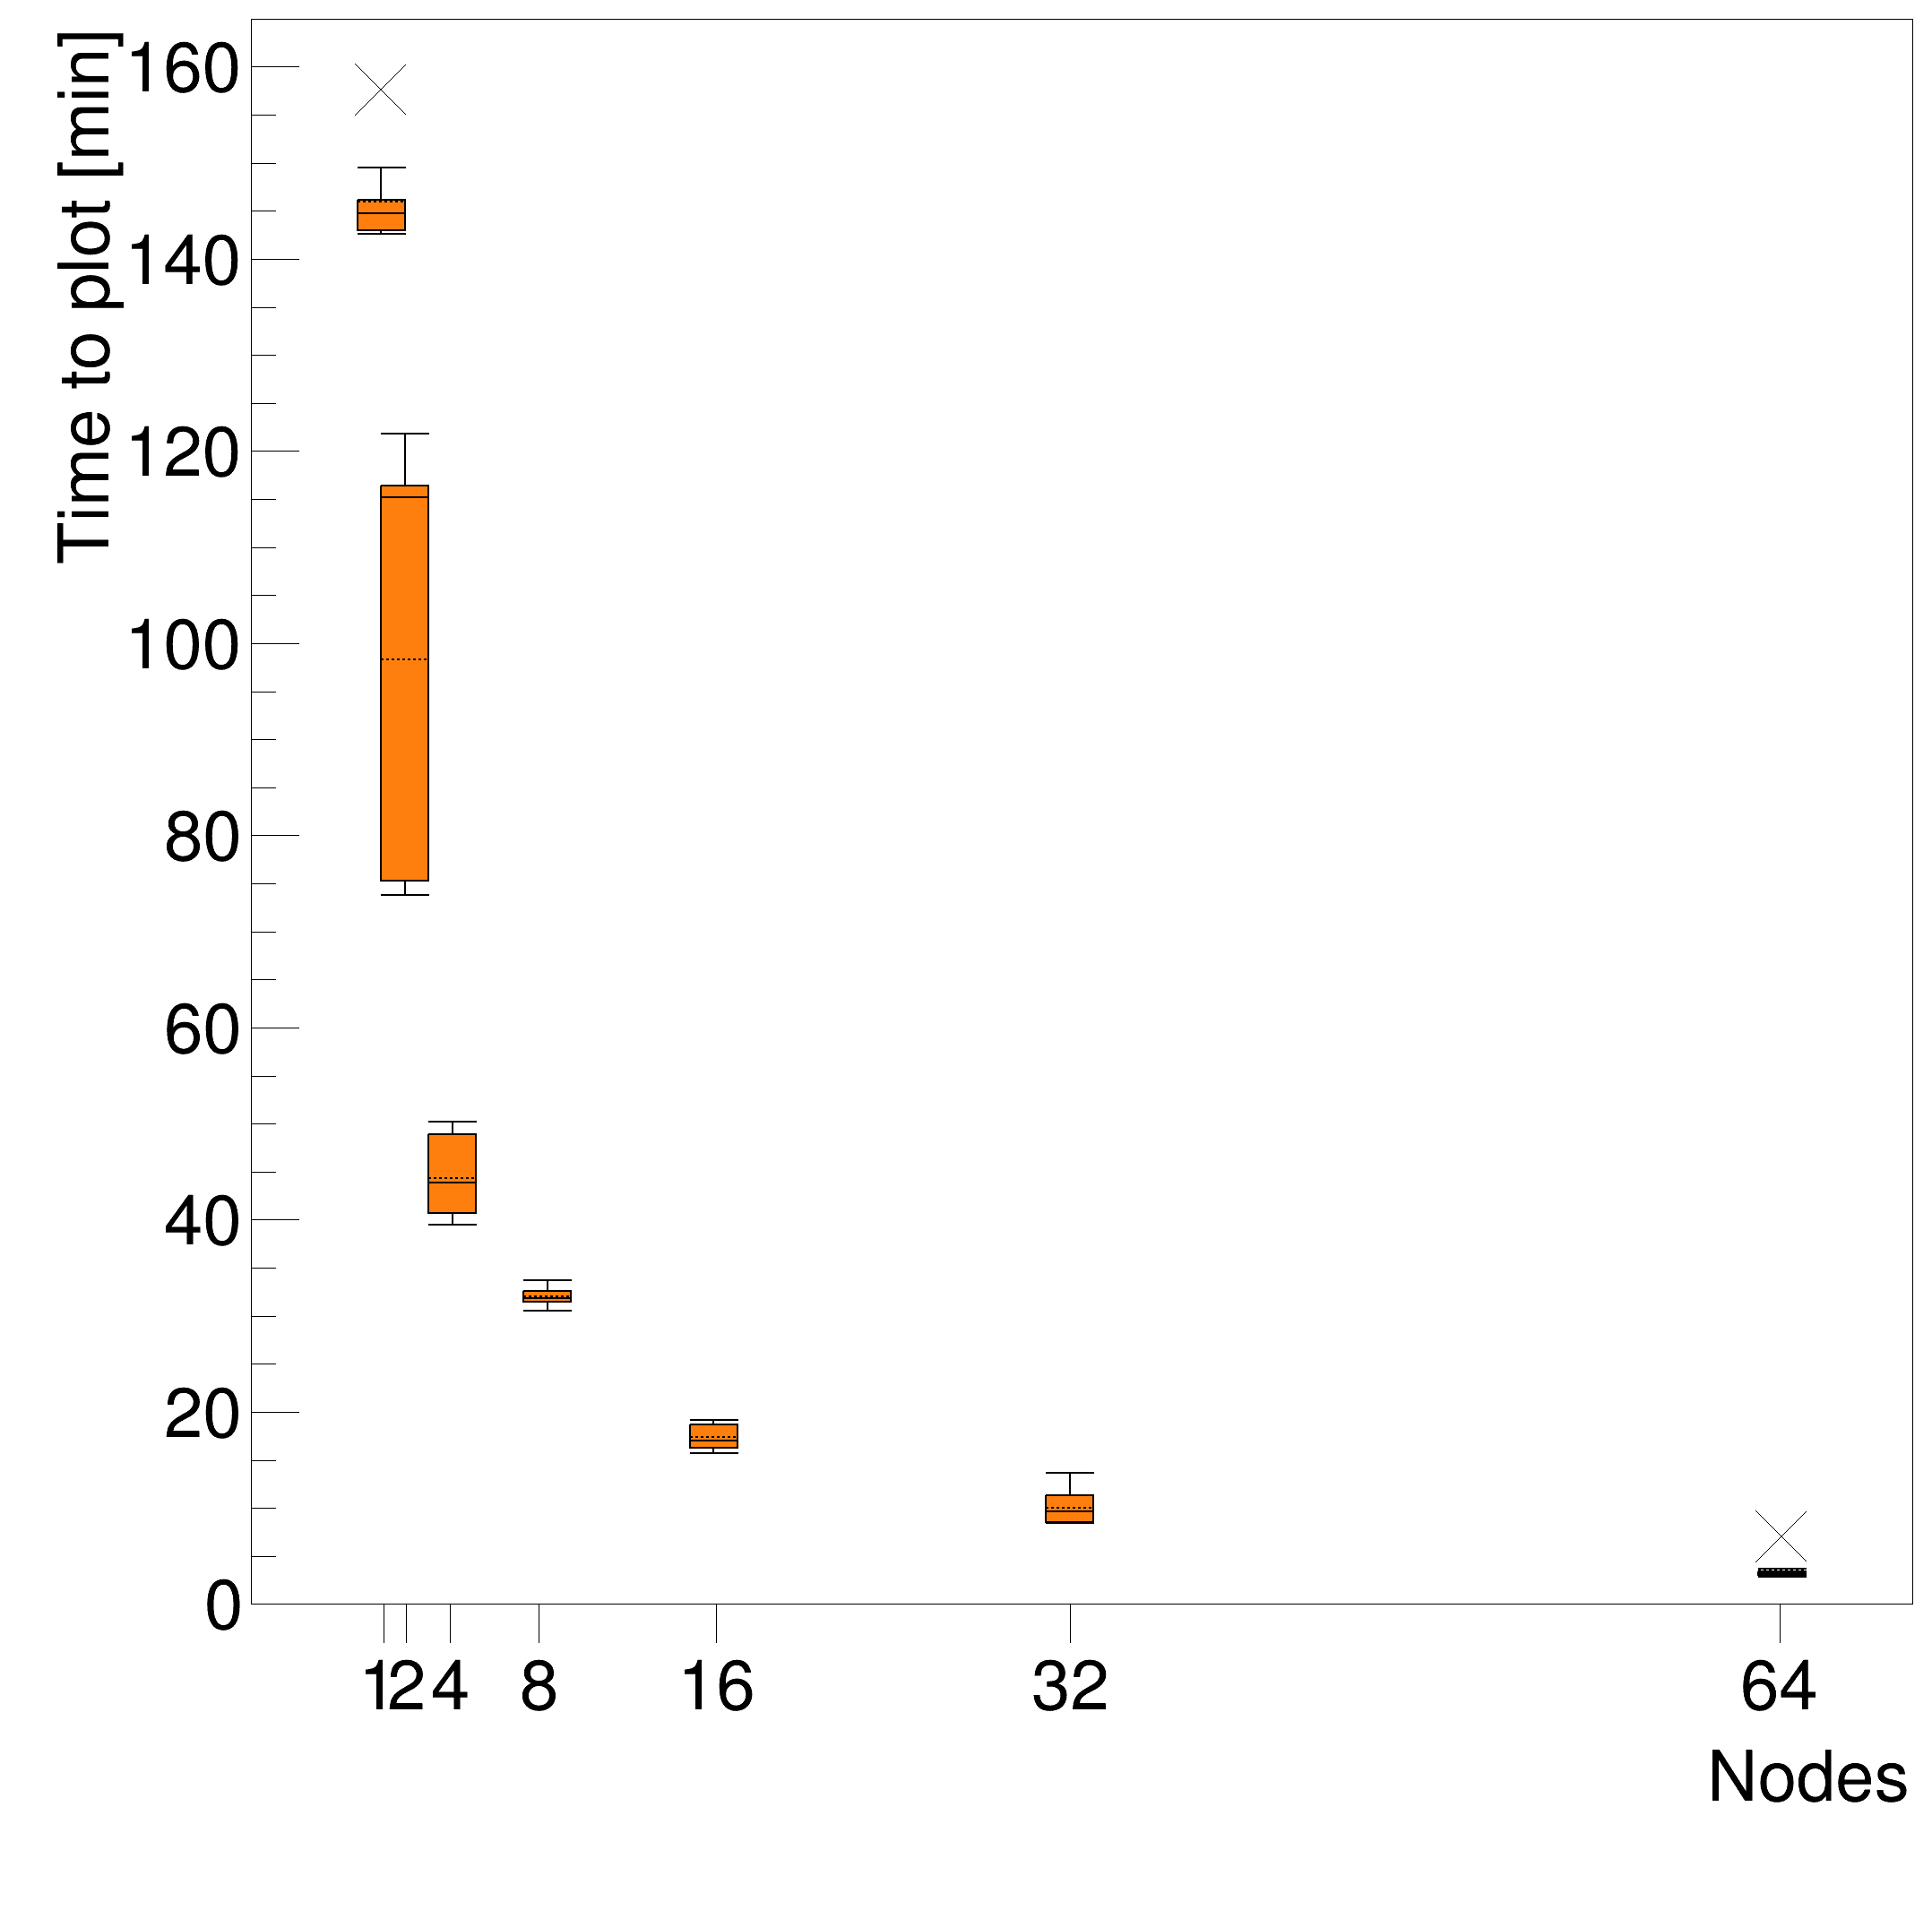

In [7]:
# Data
xcol = df1["nodes"]
ycol = df1["time_m"]
nbinsx = int(xcol.max() + 1) + 5
nbinsy = 1000
xmax = nbinsx
ymax = round_to_nearest_5(ycol.max()) + 5

# Canvas creation
width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)
c.SetRightMargin(0.01)
c.SetLeftMargin(0.13)
c.SetTopMargin(0.01)
c.SetBottomMargin(0.16)


# Histogram filling
hbox = ROOT.TH2F("hbox", "", nbinsx, -5, xmax, nbinsy, 0, ymax)
for x, y in zip(xcol, ycol):
    hbox.Fill(x, y)

# Histogram options
hbox.SetBarWidth(2)
hbox.SetBarOffset(0)
hbox.SetLineColor(ROOT.kBlack)
hbox.SetFillColor(PYPLOT_TCOLORS["tab:orange"])
hbox.SetLineWidth(2)
hbox.SetMarkerSize(10)

# X Axis options
xaxis = hbox.GetXaxis()
xaxis.SetNdivisions(nbinsx, 1, 0)
xaxis.SetTitle("Nodes")
xaxis.SetTitleOffset(1.4)
xaxis.SetTitleSize(0.04)
xaxis.SetLabelSize(0)
xaxis.SetTickLength(0)


# Y Axis options
yaxis = hbox.GetYaxis()
yaxis.SetTitle("Time to plot [min]")
yaxis.SetTitleOffset(1.3)
yaxis.SetTitleSize(0.04)
yaxis.SetLabelSize(0.04)
yaxis.SetNdivisions(10, 5, 0)

# Legend
hbox.SetStats(0)

# Draw and save
# String option for drawing: "CANDLE(zhpawMmb)"
# a = 1 anchors
# w = 2 whiskers 1.5*iqr
# M = 1 median drawn as dashed line
# m = 1 median as solid line
# b = 1 draw box
hbox.Draw("CANDLEX2")


# Custom labels on x axis
xlabels = []
xticks = []
for x in xcol.unique():
    x = int(x)
    xt = ROOT.TLatex(x, -11, str(x))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    if x == 1: # left-align the 1 node point
        xt.SetTextAlign(31)
    else:
        xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,-4)
    xl.Draw()
    xticks.append(xl)


c.Draw()
c.SaveAs("runtime_dask_remote.png")